In [7]:
from ImpLogReg import ImpLogReg
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
import itertools as it
from tqdm import tqdm
import pba

import matplotlib
font = {'size'   : 14}
matplotlib.rc('font', **font)

from LRF import *

def intervalise(val,eps,method='u',b=0,bounds = None):
    
    if method == 'u':
        m = np.random.uniform(val-eps,val+eps)
    elif method == 't':
        m = np.random.triangular(val-eps,val-b*eps,val+eps)
    
    if bounds is not None:
        if m-eps < bounds[0]:
            return pba.I(bounds[0],m+eps)
        elif m+eps >bounds[1]:
            return pba.I(m-eps,bounds[1])
        
    return pba.I(m-eps,m+eps)


def deintervalise(data, binary_cols):
    n_data = data.copy()
    for c in data.columns:
        if c in binary_cols:
            continue
        for i in data.index:
            if data.loc[i,c].__class__.__name__ == 'Interval':
                n_data.loc[i,c] = data.loc[i,c].left + np.random.rand()*data.loc[i,c].width()
            
    return n_data

### Import data
data = pd.read_table('burn1000.txt',index_col = 'ID')

results = data['DEATH']
train_data = data[[c for c in data.columns if c not in ['DEATH','FACILITY']]]

UQdata = train_data.copy()

# Split the data into test/train factors and result and generate uncertain points
random.seed(1) # for reproducability

## Select some data to be intervalised
index_list = [i for i in data.index]

ininj_index = random.sample(index_list, k = 20) 
uq_data_index = random.sample(index_list,k = 10)

u_index = ininj_index

UQdata = pd.DataFrame({
    **{
        "INH_INJ": [pba.I(0,1) if i in ininj_index else train_data.loc[i,"INH_INJ"] for i in index_list],
        "AGE": [pba.I(80,90) if train_data.loc[i,'AGE'] > 80 else train_data.loc[i,'AGE'] for i in index_list],
        "TBSA": [intervalise(train_data.loc[i,"TBSA"],1) for i in index_list]
        },
    **{c: train_data[c] for c in train_data.columns if c not in ("INH_INJ",'AGE',"TBSA")},
    }, index = data.index, dtype = 'O').reindex(columns = train_data.columns)
UQdata.to_csv('burn_uq.csv')
# uq_results = pd.Series([int(results.loc[i]) if i not in uq_data_index else pba.I(0,1) for i in results.index], index = results.index, dtype='O')


In [9]:

### Fit logistic regression model on full dataset
base = LogisticRegression(max_iter=1000)
base.fit(train_data.to_numpy(),results.to_numpy())


LogisticRegression(max_iter=1000)

In [8]:

### Fit UQ models
# uq_models = uc_int_logistic_regression(UQdata,results.drop(uq_data_index),results.loc[uq_data_index],binary_cols = ["INH_INJ"],uq_data_index=uq_data_index)
ilr = ImpLogReg(max_iter = 1000, uncertain_class=0, uncertain_data=True)
ilr.fit(UQdata, results, catagorical=["INH_INJ"])


16it [34:57, 131.11s/it]                        


/Users/nickgray/Local/LR/LR-python-code/.env/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/nickgray/Local/LR/LR-python-code/.env/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/nickgray/Local/LR/LR-python-code/.env/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
ROC: 100%|██████████| 1000/1000 [00:05<00:00, 178.63it/s]
/Users/nickgray/Local/LR/LR-python-code/.env/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/nickgray/Local/LR/LR-python-code/.env/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but L

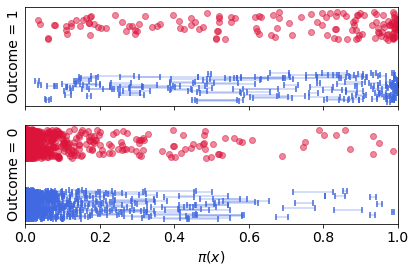

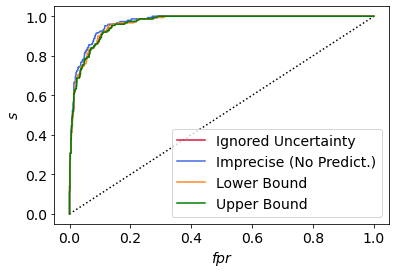

<Figure size 432x288 with 0 Axes>

In [10]:

### Get confusion matrix
# Classify test data
base_predict = base.predict(train_data)

# CLASSIFY NO_UQ MODEL DATA 
nuq_predict = nuq.predict(train_data)

# CLASSIFY UQ MODEL 
ilr_predict = ilr.predict(train_data)

with open('runinfo/burn1000_cm.out','w') as f:
    print('TRUE MODEL',file = f)
    a,b,c,d = generate_confusion_matrix(results,base_predict)
    print('TP=%i\tFP=%i\nFN=%i\tTN=%i' %(a,b,c,d),file = f)

    # Calculate sensitivity and specificity
    print('Sensitivity = %.3f' %(a/(a+c)),file = f)
    print('Specificity = %.3f' %(d/(b+d)),file = f)

    print('DISCARDED DATA MODEL',file = f)
    aa,bb,cc,dd = generate_confusion_matrix(results,nuq_predict)
    try:
        ss = 1/(1+cc/aa)
    except:
        ss = None
    try:    
        tt = 1/(1+bb/dd)
    except:
        tt = None
    print('TP=%s\tFP=%s\nFN=%s\tTN=%s' %(aa,bb,cc,dd),file = f)

    # Calculate sensitivity and specificity
    print('Sensitivity = %.3f' %(ss),file = f)
    print('Specificity = %.3f' %(tt),file = f)
    
    print('UQ MODEL',file = f)
    
    aaai,bbbi,ccci,dddi = generate_confusion_matrix(results,ilr_predict,throw = False)
    try:
        sssi = aaai/(a+c)
    except:
        sssi = None
    try:    
        ttti = dddi/(b+d)
    except:
        ttti = None

    print('TP=[%i,%i]\tFP=[%i,%i]\nFN=[%i,%i]\tTN=[%i,%i]' %(*aaai,*bbbi,*ccci,*dddi),file = f)

    # Calculate sensitivity and specificity
    print('Sensitivity = [%.3f,%.3f]\nSpecificity = [%.3f,%.3f]' %(*sssi,*ttti),file = f)

    
    aaa,bbb,ccc,ddd,eee,fff = generate_confusion_matrix(results,ilr_predict,throw = True)
    try:
        sss = 1/(1+ccc/aaa)
    except:
        sss = None
    try:    
        ttt = 1/(1+bbb/ddd)
    except:
        ttt = None
        
    print('TP=%i\tFP=%i\nFN=%i\tTN=%i\nNP(+)=%i\tNP(-)=%i' %(aaa,bbb,ccc,ddd,eee,fff),file = f)

    # Calculate sensitivity and specificity
    print('Sensitivity = %.3f' %(sss),file = f)
    print('Specificity = %.3f' %(ttt),file = f)
    print('sigma = %.3f' %(eee/(aaa+ccc+eee)),file = f)
    print('tau = %.3f' %(fff/(bbb+ddd+fff)),file = f)
   

### Descriminatory Performance Plots
# s,fpr,probabilities = ROC(model = base, data = train_data, results = results)

nuq_s,nuq_fpr,nuq_probabilities = ROC(model = nuq, data = train_data, results = results)
s_t, fpr_t, Sigma, Tau = incert_ROC(ilr, train_data, results)

s_i, fpr_i,ilr_probabilities = ROC(ilr, train_data, results)
s_l, fpr_l,ilr_l_probabilities = ROC(ilr, train_data, results, func = lambda x: x.left)
s_r, fpr_r,ilr_r_probabilities = ROC(ilr, train_data, results, func = lambda x: x.right)


densfig,axdens = plt.subplots(nrows = 2, sharex= True)

for i,(u,nuqp,r) in enumerate(zip(ilr_probabilities,nuq_probabilities,results.to_list())):
    yd = np.random.uniform(-0.1,0.1)
    if r:

        axdens[0].scatter(nuqp,0.21+yd,color = '#DC143C',marker = 'o',alpha = 0.5)
        axdens[0].plot([*u],[yd-0.21,yd-0.21],color = '#4169E1',alpha = 0.3)
        axdens[0].scatter([*u],[yd-0.21,yd-0.21],color = '#4169E1',marker = '|')
    else:

        axdens[1].scatter(nuqp,0.21+yd,color = '#DC143C',marker = 'o',alpha = 0.5)
        axdens[1].plot([*u],[yd-0.21,yd-0.21],color = '#4169E1',alpha = 0.3)
        axdens[1].scatter([*u],[yd-0.21,yd-0.21],color = '#4169E1',marker = '|')
        
        
axdens[0].set(ylabel = 'Outcome = 1',yticks = [])
axdens[1].set(xlabel = '$\pi(x)$',ylabel = 'Outcome = 0',yticks = [],xlim  = (0, 1))

densfig.tight_layout()

rocfig,axroc = plt.subplots(1,1)
axroc.plot([0,1],[0,1],'k:')
axroc.set(xlabel = '$fpr$',ylabel='$s$')
# axroc.plot(fpr,s,'k',label = 'Base')
axroc.plot(nuq_fpr,nuq_s,color='#DC143C',label='Ignored Uncertainty')
axroc.plot(fpr_t,s_t,'#4169E1',label='Imprecise (No Predict.)')
axroc.plot(fpr_l,s_l,'#FF8827',label='Lower Bound')
axroc.plot(fpr_r,s_r,'#007e00',label='Upper Bound')

axroc.legend()
rocfig.savefig('figs/burn1000_ROC.png',dpi = 600)
# rocfig.savefig('../paper/figs/burn1000_ROC.png',dpi = 600)
densfig.savefig('figs/burn1000_dens.png',dpi =600)
# densfig.savefig('../paper/figs/burn1000_dens.png',dpi =600)


with open('runinfo/burn1000_auc.out','w') as f:
    print('MIDPOINTS: %.4F' %auc(nuq_s,nuq_fpr),file = f)
    print('NP: %.4f' %auc(s_t,fpr_t), file = f)
    print('LB: %.4f' %auc(s_l,fpr_l), file = f)
    print('UB: %.4f' %auc(s_r,fpr_r), file = f)

    # print('INTERVALS: [%.3f,%.3f]' %(auc_int_min,auc_int_max), file = f)
    


fig = plt.figure()
ax = plt.axes(projection='3d',elev = 45,azim = -45,proj_type = 'ortho')
ax.set_xlabel('$fpr$')
ax.set_ylabel('$s$')
# ax.set_zlabel('$1-\sigma,1-\\tau$')
ax.plot(fpr_t,s_t,'#4169E1',alpha = 0.5)
ax.plot3D(fpr_t,s_t,Sigma,'#FF8C00',label = '$\\sigma$')
ax.plot3D(fpr_t,s_t,Tau,'#008000',label = '$\\tau$')
# ax.plot3D(fpr,s,Nu,'k',label = '$1-\\nu$')

ax.legend()

# plt.savefig('figs/burn1000_ROC3D.png',dpi = 600)
# plt.savefig('../paper/figs/burn1000_ROC3D.png',dpi = 600)
plt.clf()

plt.xlabel('$fpr$/$s$')
plt.ylabel('$\\sigma$/$\\tau$')
plt.plot(s_t,Sigma,'#FF8C00',label = '$\\sigma$ v $s$')
plt.plot(fpr_t,Tau,'#008000',label = '$\\tau$ v $fpr$')
plt.legend()


# plt.savefig('figs/burn1000_ST.png',dpi = 600)
# plt.savefig('../paper/figs/burn1000_ST.png',dpi = 600)

plt.clf()


### Hosmer-Lemeshow
hl_b, pval_b = hosmer_lemeshow_test(base,train_data,results,g = 10)

hl_nuq, pval_nuq = hosmer_lemeshow_test(nuq,train_data,results,g = 10)
#
hl_uq, pval_uq = UQ_hosmer_lemeshow_test(ilr,train_data,results,g = 10)

with open('runinfo/burn1000_HL.out','w') as f:
    print('base\nhl = %.3f, p = %.3f' %(hl_b,pval_b),file = f)
    print('no UQ\nhl = %.3f, p = %.3f' %(hl_nuq,pval_nuq),file = f) 

    print('UQ\nhl = [%.3f,%.3f], p = [%.3f,%.3f]' %(*hl_uq,*pval_uq),file = f) 

In [6]:
for k,l in ilr.models.items():
    print(k,l.feature_names_in_)

leftmost ['AGE' 'GENDER' 'RACE' 'TBSA' 'INH_INJ' 'FLAME']
rightmost ['AGE' 'GENDER' 'RACE' 'TBSA' 'INH_INJ' 'FLAME']
r_min_intercept ['AGE' 'GENDER' 'RACE' 'TBSA' 'INH_INJ' 'FLAME']
r_min_coef_0 ['AGE' 'GENDER' 'RACE' 'TBSA' 'INH_INJ' 'FLAME']
r_min_coef_1 ['AGE' 'GENDER' 'RACE' 'TBSA' 'INH_INJ' 'FLAME']
r_min_coef_2 ['AGE' 'GENDER' 'RACE' 'TBSA' 'INH_INJ' 'FLAME']
r_min_coef_3 ['AGE' 'GENDER' 'RACE' 'TBSA' 'INH_INJ' 'FLAME']
r_min_coef_4 ['AGE' 'GENDER' 'RACE' 'TBSA' 'INH_INJ' 'FLAME']
r_min_coef_5 ['AGE' 'GENDER' 'RACE' 'TBSA' 'INH_INJ' 'FLAME']
r_max_intercept ['AGE' 'GENDER' 'RACE' 'TBSA' 'INH_INJ' 'FLAME']
r_max_coef_0 ['AGE' 'GENDER' 'RACE' 'TBSA' 'INH_INJ' 'FLAME']
r_max_coef_1 ['AGE' 'GENDER' 'RACE' 'TBSA' 'INH_INJ' 'FLAME']
r_max_coef_2 ['AGE' 'GENDER' 'RACE' 'TBSA' 'INH_INJ' 'FLAME']
r_max_coef_3 ['AGE' 'GENDER' 'RACE' 'TBSA' 'INH_INJ' 'FLAME']
r_max_coef_4 ['AGE' 'GENDER' 'RACE' 'TBSA' 'INH_INJ' 'FLAME']
r_max_coef_5 ['AGE' 'GENDER' 'RACE' 'TBSA' 'INH_INJ' 'FLAME']
